# Get point cloud from Waymo v2 format

In [37]:
#@title Initial setup
from typing import Optional
import warnings
# Disable annoying warnings from PyArrow using under the hood.
warnings.simplefilter(action='ignore', category=FutureWarning)
from platform import python_version
print(python_version())
import numpy as np


import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import dask.dataframe as dd
from waymo_open_dataset import v2
from waymo_open_dataset.utils import  frame_utils


# Path to the directory with all components
dataset_dir = '/home/wod_v2/src/data/perception_2.0.0/training'

context_name = '10023947602400723454_1120_000_1140_000'

def read(tag: str) -> dd.DataFrame:
  """Creates a Dask DataFrame for the component specified by its tag."""
  paths = tf.io.gfile.glob(f'{dataset_dir}/{tag}/{context_name}.parquet')
  return dd.read_parquet(paths)



# Lazily read DataFrames for all components.
association_df = read('camera_to_lidar_box_association')
cam_box_df = read('camera_box')
cam_img_df = read('camera_image')
lidar_box_df = read('lidar_box')
lidar_df = read('lidar')
lidar_calibration_df = read('lidar_calibration')

association_df = association_df[association_df['key.camera_name'] == 1]
cam_box_df = cam_box_df[cam_box_df['key.camera_name'] == 1].compute()
cam_img_df = cam_img_df[cam_img_df['key.camera_name'] == 1].compute()
lidar_df = lidar_df[lidar_df['key.laser_name'] == 1]
lidar_calibration_df = lidar_calibration_df[lidar_calibration_df['key.laser_name'] == 1].compute()

# Join all DataFrames using matching columns
cam_image_w_box_df = v2.merge(cam_box_df, cam_img_df)
cam_obj_df = v2.merge(association_df, cam_image_w_box_df)
# In this example camera box labels are optional, so we set left_nullable=True.
obj_df = v2.merge(cam_obj_df, lidar_box_df, left_nullable=True)
# Group lidar sensors (left), group labels and camera images (right) and join.
df = v2.merge(lidar_df, obj_df, left_group=True, right_group=True)

3.10.14
2.12.0
Num GPUs Available:  1


In [38]:
# Read a single row, which contain data for all data for a single frame.
_, row = next(iter(df.iterrows()))
# Create all component objects
camera_image = v2.CameraImageComponent.from_dict(row)
lidar = v2.LiDARComponent.from_dict(row)
camera_box = v2.CameraBoxComponent.from_dict(row)
lidar_box = v2.LiDARBoxComponent.from_dict(row)
lidar_calibration = v2.LiDARCalibrationComponent.from_dict(lidar_calibration_df)

print(
    f'Found {len(lidar_box.key.laser_object_id)} objects on'
    f' {lidar.key.segment_context_name=} {lidar.key.frame_timestamp_micros=}'
)
for laser_object_id, camera_object_id, camera_name in zip(
    lidar_box.key.laser_object_id,
    camera_box.key.camera_object_id,
    camera_image.key.camera_name
    # camera_box.key.
):
  print(f'\t{laser_object_id=} {camera_object_id=} {camera_name=}')

Found 78 objects on lidar.key.segment_context_name='10023947602400723454_1120_000_1140_000' lidar.key.frame_timestamp_micros=1552440195362591
	laser_object_id='-U88NMYnocLWCh6iqZwj1g' camera_object_id=nan camera_name=nan
	laser_object_id='0VCoeT-jjrIfzTCsOWz20A' camera_object_id=nan camera_name=nan
	laser_object_id='0_HBXNo3olLueqYvkPohlg' camera_object_id=nan camera_name=nan
	laser_object_id='1nDCER_bA9py1ZPpNXecog' camera_object_id=nan camera_name=nan
	laser_object_id='2-A6zakvKX2opVnyx9gplQ' camera_object_id='a6f937a6-7ea8-4393-b636-e0560e699856' camera_name=1.0
	laser_object_id='2OYKagQRfCdaOXgU5RkMBA' camera_object_id=nan camera_name=nan
	laser_object_id='2SYmRAjI0pCOwp2XYemMBQ' camera_object_id='ba670814-995e-4ade-bc42-58b0a1d8ec8d' camera_name=1.0
	laser_object_id='3083QteOhZ_vSpxmP0XK-Q' camera_object_id=nan camera_name=nan
	laser_object_id='38Np8bwqcvw9KkrH3xHfpg' camera_object_id=nan camera_name=nan
	laser_object_id='3I9vmrICjjnWtavq3ysJrQ' camera_object_id=nan camera_name=na

In [39]:
# Get Range image of top lidar
range_image_orig = lidar.range_image_return1

range_image = v2.perception.lidar.RangeImage(lidar.range_image_return1.values[0], lidar.range_image_return1.shape[0])

print(range_image)
print(type(range_image.values))
print(range_image.shape)

temp_tfm = v2.column_types.Transform
temp_tfm.transform = lidar_calibration.extrinsic.transform.tolist()[0]
temp_bic = v2.perception.context.BeamInclination
temp_bic.min = lidar_calibration.beam_inclination.min
temp_bic.max = lidar_calibration.beam_inclination.max
temp_bic.values = lidar_calibration.beam_inclination.values.tolist()[0]

lc2 = v2.perception.context.LiDARCalibrationComponent(lidar_calibration.key, temp_tfm, temp_bic)

print(lidar_calibration.extrinsic.transform.tolist()[0])
print(type(lidar_calibration.extrinsic))
print(type(lidar_calibration.extrinsic.transform))
print(type(lidar_calibration_df))
print(type(lidar_calibration))
# extrinsic = tf.convert_to_tensor(lidar_calibration.extrinsic.transform)

# TODO: Eventually should add pixel_pose and frame_pose when mulitple cameras are used
points = v2.perception.utils.lidar_utils.convert_range_image_to_point_cloud(range_image, lc2, keep_polar_features=True)


RangeImage(values=array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32), shape=array([  64, 2650,    4], dtype=int32))
<class 'numpy.ndarray'>
[  64 2650    4]
[-8.50486534e-01 -5.25981865e-01 -3.96644352e-03  1.43000000e+00
  5.25971210e-01 -8.50495357e-01  3.45458508e-03  0.00000000e+00
 -5.19049090e-03  8.51842992e-04  9.99986166e-01  2.18400000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
<class 'waymo_open_dataset.v2.column_types.Transform'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'waymo_open_dataset.v2.perception.context.LiDARCalibrationComponent'>


In [4]:
print(points.shape)
print(points[:,4])

(149796, 6)
tf.Tensor([ 4.752197   4.3479753  8.619505  ... -1.8297869 -1.8156391 -1.7855257], shape=(149796,), dtype=float32)


# Pipeline to yolo bev format

In [40]:
import cv2
import numpy as np


# create birds-eye view of lidar data
def bev_from_pcl(lidar_pcl, configs, viz=False, verbose=False):
    # remove lidar points outside detection area and with too low reflectivity
    mask = np.where((lidar_pcl[:, POINTCLOUD_X_INDEX] >= configs['lim_x'][0]) & (lidar_pcl[:, POINTCLOUD_X_INDEX] <= configs['lim_x'][1]) &
                    (lidar_pcl[:, POINTCLOUD_Y_INDEX] >= configs['lim_y'][0]) & (lidar_pcl[:, POINTCLOUD_Y_INDEX] <= configs['lim_y'][1]))# &
                    #(lidar_pcl[:, POINTCLOUD_Z_INDEX] >= configs['lim_z'][0]) & (lidar_pcl[:, POINTCLOUD_Z_INDEX] <= configs['lim_z'][1]))
    lidar_pcl = lidar_pcl[mask]
    
    # shift level of ground plane to avoid flipping from 0 to 255 for neighboring pixels
    lidar_pcl[:, POINTCLOUD_Z_INDEX] = lidar_pcl[:, POINTCLOUD_Z_INDEX] - configs['lim_z'][0]  

    if verbose:
        print(lidar_pcl[0,:])
        print('Min and max height, %f, %f' %(np.min(lidar_pcl[:,2]), np.max(lidar_pcl[:,2])))

    # convert sensor coordinates to bev-map coordinates (center is bottom-middle)

    ## step 1 : compute bev-map discretization by dividing x-range by the bev-image height (see configs)
    delta_x_rw_meters = configs['lim_x'][1] - configs['lim_x'][0]
    delta_y_rw_meters = configs['lim_y'][1] - configs['lim_y'][0]
    meters_pixel_x = delta_x_rw_meters / configs['bev_height']
    meters_pixel_y = delta_y_rw_meters / configs['bev_width']

    ## step 2 : create a copy of the lidar pcl and transform all metrix x-coordinates into bev-image coordinates  
    lidar_pcl_copy = np.copy(lidar_pcl)
    lidar_pcl_copy[:, POINTCLOUD_X_INDEX] = np.int_(np.floor(lidar_pcl_copy[:, POINTCLOUD_X_INDEX] / meters_pixel_x))  

    # step 3 : perform the same operation as in step 2 for the y-coordinates but make sure that no negative bev-coordinates occur
    lidar_pcl_copy[:, POINTCLOUD_Y_INDEX] = np.int_(np.floor(lidar_pcl_copy[:, POINTCLOUD_Y_INDEX] / meters_pixel_y) + (configs['bev_width'] + 1) / 2)

    # step 4 : visualize point-cloud using the function show_pcl from a previous task
    # if viz:
    #     show_pcl(lidar_pcl_copy)
   
   
    # Compute intensity layer of the BEV map

    ## step 1 : create a numpy array filled with zeros which has the same dimensions as the BEV map
    intensity_map = np.zeros((configs['bev_height'] + 1, configs['bev_width'] + 1))

    # step 2 : re-arrange elements in lidar_pcl_cpy by sorting first by x, then y, then -z (use numpy.lexsort)
    lidar_pcl_copy[lidar_pcl_copy[:, POINTCLOUD_INTENSITY] > 1.0, POINTCLOUD_INTENSITY] = 1.0
    index_vector_int = np.lexsort((-lidar_pcl_copy[:, POINTCLOUD_INTENSITY], lidar_pcl_copy[:, POINTCLOUD_Y_INDEX], lidar_pcl_copy[:, POINTCLOUD_X_INDEX]))
    lidar_pcl_top = lidar_pcl_copy[index_vector_int]

    ## step 3 : extract all points with identical x and y such that only the top-most z-coordinate is kept (use numpy.unique)
    ##          also, store the number of points per x,y-cell in a variable named "counts" for use in the next task
    _, idx_int_unique, counts = np.unique(lidar_pcl_top[:, POINTCLOUD_X_INDEX:POINTCLOUD_Z_INDEX], return_index=True, return_inverse=False, return_counts=True, axis=0)
    lidar_pcl_top = lidar_pcl_top[idx_int_unique]

    intensity_map = np.zeros((configs['bev_height'] + 1, configs['bev_width'] + 1))
    
    ## step 4 : assign the intensity value of each unique entry in lidar_pcl_top to the intensity map 
    ##          make sure that the intensity is scaled in such a way that objects of interest (e.g. vehicles) are clearly visible    
    ##          also, make sure that the influence of outliers is mitigated by normalizing intensity on the difference between the max. and min. value within the point cloud
    intensity_map[np.int_(lidar_pcl_top[:, POINTCLOUD_X_INDEX]), np.int_(lidar_pcl_top[:, POINTCLOUD_Y_INDEX])] = lidar_pcl_top[:, POINTCLOUD_INTENSITY] / (np.amax(lidar_pcl_top[:, POINTCLOUD_INTENSITY]) - np.amin(lidar_pcl_top[:, POINTCLOUD_INTENSITY]))

    # if viz:
    #     analyze({'before': lidar_pcl_top_copy, 'after': lidar_pcl_top_copy_post}, title='Intensity Distribution', nqp=False)

    ## step 5 : temporarily visualize the intensity map using OpenCV to make sure that vehicles separate well from the background
    img_intensity = intensity_map * 255
    img_intensity = img_intensity.astype(np.uint8)
    if viz:
        while (1):
            cv2.imshow('img_intensity', img_intensity)
            if cv2.waitKey(10) & 0xFF == 27:
                break
        cv2.destroyAllWindows

   

    # Compute height layer of the BEV map

    ## step 1 : create a numpy array filled with zeros which has the same dimensions as the BEV map
    height_map = np.zeros((configs['bev_height'] + 1, configs['bev_width'] + 1))

    ## step 2 : assign the height value of each unique entry in lidar_top_pcl to the height map
    ##          make sure that each entry is normalized on the difference between the upper and lower height defined in the config file
    ##          use the lidar_pcl_top data structure from the previous task to access the pixels of the height_map
    # _, idx_height_unique, counts = np.unique(lidar_pcl_top[:, 0:2], return_index=True, return_inverse=False, return_counts=True, axis=0)
    # lidar_pcl_hei = lidar_pcl_top[idx_height_unique]
    height_map[np.int_(lidar_pcl_top[:, POINTCLOUD_X_INDEX]), np.int_(lidar_pcl_top[:, POINTCLOUD_Y_INDEX])] = lidar_pcl_top[:, POINTCLOUD_Z_INDEX] / float(np.abs(configs['lim_z'][1] - configs['lim_z'][0]))

    ## step 3 : temporarily visualize the intensity map using OpenCV to make sure that vehicles separate well from the background
    img_height = height_map * 256
    img_height = img_height.astype(np.uint8)
    if viz:
        while (1):
            cv2.imshow('img_height', img_height)
            if cv2.waitKey(10) & 0xFF == 27:
                break
        cv2.destroyAllWindows

    #######
    ####### ID_S2_EX3 END #######       

    # TODO remove after implementing all of the above steps
    # lidar_pcl_cpy = []
    # lidar_pcl_top = []
    # height_map = []
    # intensity_map = []

    # Compute density layer of the BEV map


    density_map = np.zeros((configs['bev_height'] + 1, configs['bev_width'] + 1))
    _, _, counts = np.unique(lidar_pcl_copy[:, POINTCLOUD_X_INDEX:POINTCLOUD_Z_INDEX], axis=0, return_index=True, return_counts=True)
    normalizedCounts = np.minimum(1.0, np.log(counts + 1) / np.log(64)) 
    density_map[np.int_(lidar_pcl_top[:, POINTCLOUD_X_INDEX]), np.int_(lidar_pcl_top[:, POINTCLOUD_Y_INDEX])] = normalizedCounts

    
    if viz:
        while (1):
            cv2.imshow('density map', density_map)
            if cv2.waitKey(10) & 0xFF == 27:
                break
        cv2.destroyAllWindows
    
    # assemble 3-channel bev-map from individual maps
    bev_map = np.zeros((3, configs['bev_height'], configs['bev_width']))
    bev_map[2, :, :] = density_map[:configs['bev_height'], :configs['bev_width']]  # r_map
    bev_map[1, :, :] = height_map[:configs['bev_height'], :configs['bev_width']]  # g_map
    bev_map[0, :, :] = intensity_map[:configs['bev_height'], :configs['bev_width']]  # b_map
    
    bev_map_cpy = np.zeros((configs['bev_height'], configs['bev_width'], 3))
    bev_map_cpy[:, :, 2] = density_map[:configs['bev_height'], :configs['bev_width']] /  density_map.max() # r_map
    bev_map_cpy[:, :, 1] = height_map[:configs['bev_height'], :configs['bev_width']] / height_map.max() # g_map
    bev_map_cpy[:, :, 0] = intensity_map[:configs['bev_height'], :configs['bev_width']] / intensity_map.max() # b_map

    # expand dimension of bev_map before converting into a tensor
    s1, s2, s3 = bev_map.shape
    bev_maps = np.zeros((1, s1, s2, s3))
    bev_maps[0] = bev_map

    if viz:
        print(bev_map_cpy.shape)
        # bev_map_cpy = np.reshape(bev_map, (bev_map.shape[1], bev_map.shape[2], bev_map.shape[0]))
        print( intensity_map.max(), height_map.max(), density_map.max())
        while (1):
            cv2.imshow('bev_map', bev_map_cpy)
            if cv2.waitKey(10) & 0xFF == 27:
                break
        cv2.destroyAllWindows
    # bev_maps = torch.from_numpy(bev_maps)  # create tensor from birds-eye view
    # input_bev_maps = bev_maps.to(configs[device], non_blocking=True).float()

    # show_bev(input_bev_maps, configs)

    return bev_maps

In [41]:
configs = {}
configs['lim_x'] = [0,53]
configs['lim_y'] = [-20,20]
configs['lim_z'] = [-3.1, 2]
configs['lim_r'] = [0, 1.0]
configs['bev_height'] = 640
configs['bev_width'] = 480

# points_xyzl = points[:, :4]
# points_xyzl[:, :2] = points[:, 3:5]
# points_xyzl[:, 3] = points[:, 1]
POINTCLOUD_X_INDEX = 3
POINTCLOUD_Y_INDEX = 4
POINTCLOUD_Z_INDEX = 5
POINTCLOUD_INTENSITY = 1
# print(points_xyzl[:, POINTCLOUD_Z_INDEX].min(), ' ', points_xyzl[:, POINTCLOUD_Z_INDEX].max())

points_cpu = points.numpy()
bev_map = bev_from_pcl(points_cpu, configs, viz=False)

### Pipeline for Yolov8

In [12]:
from ultralytics import YOLO

model = YOLO("yolov8n.yaml")
results = model.train(data="coco8.yaml")

Ultralytics YOLOv8.2.77 🚀 Python-3.10.14 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3080, 11941MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=coco8.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433k/433k [00:00<00:00, 29.5MB/s]
Unzipping /home/wod_v2/src/datasets/coco8.zip to /home/wod_v2/src/datasets/coco8...: 100%|██████████| 25/25 [00:00<00:00, 5473.31file/s]

Dataset download success ✅ (0.3s), saved to /home/wod_v2/src/datasets




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 755k/755k [00:00<00:00, 41.7MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6.25M/6.25M [00:00<00:00, 84.4MB/s]


AMP: checks passed ✅


train: Scanning /home/wod_v2/src/datasets/coco8/labels/train... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 676.58it/s]

train: New cache created: /home/wod_v2/src/datasets/coco8/labels/train.cache



val: Scanning /home/wod_v2/src/datasets/coco8/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 749.15it/s]

val: New cache created: /home/wod_v2/src/datasets/coco8/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.705G      2.637      5.414      4.358         21        640: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.638G      3.188       5.59      4.229         36        640: 100%|██████████| 1/1 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.638G      3.238      5.813       4.46         20        640: 100%|██████████| 1/1 [00:00<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.635G      3.269      5.498      4.225         21        640: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.74it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.659G      3.806      5.664      4.331         19        640: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 40.85it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.667G      2.883      5.544      4.371         22        640: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 41.34it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.654G      3.631      5.733      4.255         20        640: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 40.74it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.669G      3.382      5.525      4.181         20        640: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 40.70it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.659G      3.037      5.497      4.569         20        640: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.24it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.669G      3.272      5.517      4.516         25        640: 100%|██████████| 1/1 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 42.30it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.661G      3.156      5.613      4.276         31        640: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.58it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.669G      3.065      5.567       4.28         31        640: 100%|██████████| 1/1 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 36.87it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.661G      3.315      5.448        4.2         24        640: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 40.50it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.667G      2.827      5.723       4.29         15        640: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.661G      3.319       5.42      4.244         38        640: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.55it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.682G      3.281      5.519       4.32         49        640: 100%|██████████| 1/1 [00:00<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 40.06it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.659G      3.066      5.464      4.416         25        640: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.64it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.663G      2.922      5.801      4.276         16        640: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 41.80it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.669G      2.739      5.557      4.286         34        640: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 38.43it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.659G      2.897      5.755      4.339         25        640: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.39it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.679G      3.111      5.536      4.269         26        640: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.81it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.698G      3.017      5.602      4.242         52        640: 100%|██████████| 1/1 [00:00<00:00, 18.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.12it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.671G      3.015      5.484      4.433         22        640: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.93it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.673G      3.255        5.5      4.213         34        640: 100%|██████████| 1/1 [00:00<00:00, 15.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.65it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.673G      3.014      5.589      4.265         11        640: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 38.10it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.679G      3.312      5.655      4.235         35        640: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.679G      2.785      5.436      4.273         24        640: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.10it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.667G      3.036      5.719       4.25         35        640: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 39.92it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.677G      3.487      5.639      4.443         28        640: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 39.52it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.669G      3.422      5.549      4.303         29        640: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.37it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.679G      3.532      5.604      4.226         25        640: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.46it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.667G      2.828      5.471      4.229         20        640: 100%|██████████| 1/1 [00:00<00:00, 16.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 39.02it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.679G      3.219      5.514      4.425         31        640: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 38.07it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.669G      3.446      5.369      4.298         32        640: 100%|██████████| 1/1 [00:00<00:00, 16.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 38.64it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.671G      3.243      5.647      4.296         23        640: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.02it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.661G      3.577      5.435      4.217         34        640: 100%|██████████| 1/1 [00:00<00:00, 14.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 39.31it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.677G      2.956       5.49      4.345         34        640: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.69it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.667G      2.926      5.579      4.265         29        640: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.79it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.679G      3.178       5.48       4.32         25        640: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.72it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.667G      2.794      5.451      4.264         19        640: 100%|██████████| 1/1 [00:00<00:00, 16.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 39.95it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.679G      3.125      5.484      4.316         29        640: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.49it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.667G      3.476      5.513      4.347         34        640: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.84it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.679G      3.048      5.427      4.298         20        640: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 39.97it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.669G      2.948      5.299      4.372         23        640: 100%|██████████| 1/1 [00:00<00:00, 18.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.44it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.682G      2.928       5.38      4.244         40        640: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.91it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.669G      3.258      5.544      4.239         23        640: 100%|██████████| 1/1 [00:00<00:00, 15.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.53it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.669G      3.223      5.836      4.214         14        640: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 39.85it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.659G      3.213      5.584      4.262         31        640: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.67it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.675G      3.497      5.544      4.319         17        640: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.25it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.669G       3.03      5.359       4.27         31        640: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.56it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.682G      3.148      5.426       4.23         35        640: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.64it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.682G      3.537      5.346      4.264         55        640: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.66it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.675G      2.799      5.507      4.262         14        640: 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.58it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.679G      3.104      5.355      4.283         46        640: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.94it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.669G      3.468      5.372      4.242         30        640: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.679G      2.964      5.512      4.204         22        640: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.679G      3.066      5.427      4.289         28        640: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.40it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.663G      3.061      5.603      4.559         11        640: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.19it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.667G      2.653      5.421       4.34         16        640: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.05it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.671G      3.109      5.221      4.399         30        640: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.46it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.661G       3.48      5.523      4.347         26        640: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.82it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.677G       2.93      5.516      4.231         20        640: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.41it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.673G      3.046      5.553      4.387         16        640: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 32.30it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.669G      3.173      5.436      4.387         26        640: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 39.18it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.671G      3.225      5.406       4.25         37        640: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.73it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.673G      3.389      5.306       4.21         51        640: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 38.50it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.673G      3.066      5.314      4.285         37        640: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 38.54it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.679G      3.071      5.539      4.313         31        640: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 43.49it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.679G      2.762      5.378      4.359         12        640: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 40.51it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.661G       3.21      6.144      4.347          9        640: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 42.10it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.673G      3.264      5.475      4.249         23        640: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 43.39it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.675G      2.755      5.487      4.228         21        640: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 42.63it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.667G      2.708      5.497      4.235         15        640: 100%|██████████| 1/1 [00:00<00:00, 19.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 38.37it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.682G      3.226       5.42      4.201         28        640: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 42.91it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.677G      3.145      5.521      4.282         60        640: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 29.77it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.667G      3.197       5.46      4.274         14        640: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.51it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.694G      3.021      5.513      4.266         37        640: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.61it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.692G      2.954      5.388      4.197         45        640: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.661G      3.661      5.774       4.18         16        640: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.43it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.667G      3.377      5.293      4.292         21        640: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 41.27it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       0.7G      3.023       5.32      4.264         42        640: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 39.75it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.659G      2.555      5.356      4.234         32        640: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.677G      3.331      5.622      4.253         31        640: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 39.68it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.682G       2.95      5.349      4.187         30        640: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 41.45it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.669G      3.198      5.214       4.25         26        640: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.03it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.679G      3.242      5.345      4.254         24        640: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 36.48it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.679G      2.931      5.224      4.254         31        640: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 33.23it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.692G      3.464      5.437      4.192         47        640: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.62it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.667G      2.922      5.424      4.275         26        640: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.677G      2.951      5.679      4.294         31        640: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 38.11it/s]

                   all          4         17          0          0          0          0


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.679G      2.756       5.43       4.25         13        640: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


                   all          4         17          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.677G      2.865      5.354      4.336         13        640: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.667G      2.881      5.409      4.305         13        640: 100%|██████████| 1/1 [00:00<00:00, 15.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.679G      2.704      5.362      4.273         13        640: 100%|██████████| 1/1 [00:00<00:00, 19.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 42.05it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.679G       2.59      5.471      4.207         13        640: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.50it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.679G      2.601       5.48      4.225         13        640: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 40.61it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.667G      2.978      5.398      4.384         13        640: 100%|██████████| 1/1 [00:00<00:00, 18.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 39.14it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.671G       2.94      5.635      4.252         13        640: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.36it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.671G      2.526      5.451      4.334         13        640: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.22it/s]

                   all          4         17          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.669G      2.789      5.439      4.258         13        640: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 39.16it/s]

                   all          4         17          0          0          0          0



100 epochs completed in 0.016 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.77 🚀 Python-3.10.14 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3080, 11941MiB)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 77.90it/s]

                   all          4         17          0          0          0          0


Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/train


# Visualizations

In [42]:
def rotate_mtx(points, angle, center):
    rotation = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
    p = points - center
    p = p.dot(rotation)
    # print(p.shape)
    return p + center
    

def distance_to_pixel(box):
    w_ = configs['bev_height'] / (configs['lim_x'][1] - configs['lim_x'][0])
    l_ = configs['bev_width'] / (configs['lim_y'][1] - configs['lim_y'][0])
    x1 = (box[0] - box[2] / 2 - configs['lim_x'][0]) * w_
    x2 = (box[0] + box[2] / 2 - configs['lim_x'][0]) * w_
    y1 = (box[1] - box[3] / 2 - configs['lim_y'][0]) * l_
    y2 = (box[1] + box[3] / 2 - configs['lim_y'][0]) * l_
    # points = np.array([[x1,y1],[x2,y1],[x1,y2],[x2,y2]])
    return np.array([[y1,x1],[y1,x2],[y2,x2],[y2,x1]])
    # return rotate(points, box[4])
    
    # points = np.array([x1,y1,x2,y2]).astype(int)
    # return points

def distance_to_pixel2(box):
    w_ = configs['bev_height'] / (configs['lim_x'][1] - configs['lim_x'][0])
    l_ = configs['bev_width'] / (configs['lim_y'][1] - configs['lim_y'][0])
    x1 = (box[0] - box[2] / 2 - configs['lim_x'][0]) * w_
    x2 = (box[0] + box[2] / 2 - configs['lim_x'][0]) * w_
    y1 = (box[1] - box[3] / 2 - configs['lim_y'][0]) * l_
    y2 = (box[1] + box[3] / 2 - configs['lim_y'][0]) * l_
    # points = np.array([[x1,y1],[x2,y1],[x1,y2],[x2,y2]])
    # return np.array([[y1,x1],[y1,x2],[y2,x2],[y2,x1]])
    # return rotate(points, box[4])
    
    points = np.array([x1,y1,x2,y2]).astype(int)
    return points

In [43]:
# Get box
print(type(lidar_box.box.center.x))

colors = [(0,100,100),(100,100,0), (100, 0, 100),(25,25,100)] #  Cyclists, Vehicles, Pedestrians, Signs

POINTCLOUD_X_INDEX = 0
POINTCLOUD_Y_INDEX = 1
lidar_box_masked = np.transpose(np.array([
    np.array(lidar_box.box.center.x), 
    np.array(lidar_box.box.center.y), 
    np.array(lidar_box.box.size.x), 
    np.array(lidar_box.box.size.y), 
    np.array(lidar_box.box.heading), 
    np.array(lidar_box.type)]))
print(lidar_box_masked[0, :])
mask = np.where((lidar_box_masked[:, POINTCLOUD_X_INDEX] >= configs['lim_x'][0]) & (lidar_box_masked[:, POINTCLOUD_X_INDEX] <= configs['lim_x'][1]) &
                (lidar_box_masked[:, POINTCLOUD_Y_INDEX] >= configs['lim_y'][0]) & (lidar_box_masked[:, POINTCLOUD_Y_INDEX] <= configs['lim_y'][1]))# &
                #(lidar_pcl[:, POINTCLOUD_Z_INDEX] >= configs['lim_z'][0]) & (lidar_pcl[:, POINTCLOUD_Z_INDEX] <= configs['lim_z'][1]))
lidar_box_masked = lidar_box_masked[mask]
print(lidar_box_masked.shape)
print(bev_map[0,0,:,:].shape)

bev_map_cpy = np.zeros((configs['bev_height'], configs['bev_width'], 3))
bev_map_cpy[:, :, 2] = bev_map[0,2,:configs['bev_height'], :configs['bev_width']] / bev_map[0,2,:,:].max() # r_map
bev_map_cpy[:, :, 1] = bev_map[0,1,:configs['bev_height'], :configs['bev_width']] / bev_map[0,1,:,:].max() # g_map
bev_map_cpy[:, :, 0] = bev_map[0,0,:configs['bev_height'], :configs['bev_width']] / bev_map[0,0,:,:].max() # b_map


for box in lidar_box_masked:
    # print("x: ", box[0], " y: ", box[1], " w: ", box[2], " l: ", box[3])
    xyxy = distance_to_pixel(box)
    # print("xy top left: ", xyxy[0], " xy bottom right: ", xyxy[2])
    # cv2.rectangle(bev_map_cpy, (int(xyxy[0][0]), int(xyxy[0][1]), int(xyxy[2][0]), int(xyxy[2][1])), thickness=2, color=(100,0,100))
    # xyxy2 = distance_to_pixel2(box)
    # cv2.rectangle(bev_map_cpy, (int(xyxy2[1]), int(xyxy2[0])), (int(xyxy2[3]), int(xyxy2[2])), thickness=2, color=(100,0,100))

    
    c = ((box[0] - configs['lim_x'][0]) * configs['bev_height'] / (configs['lim_x'][1] - configs['lim_x'][0]), (box[1] - configs['lim_y'][0]) * configs['bev_width'] / (configs['lim_y'][1] - configs['lim_y'][0]))
    rotated = rotate_mtx(xyxy, box[4], (c[1],c[0]))
    cv2.drawContours(bev_map_cpy, [rotated.astype(int)], -1, thickness=2, color=colors[int(box[5])])
    # cv2.putText(bev_map, names[int(cls)], (int(xyxy[0]), int(xyxy[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color=(100,100,0), thickness=2)

tmp = 0
while (1): 
    rotated = rotate_mtx(xyxy, tmp, (c[1],c[0]))
    # cv2.drawContours(bev_map_cpy, [rotated.astype(int)], -1, thickness=2, color=(100,100,0))
    cv2.imshow('bev_map2', bev_map_cpy)
    tmp = tmp + 0.5
    if cv2.waitKey(10) & 0xFF == 27:
        break
cv2.destroyAllWindows

<class 'list'>
[-20.86353529   3.07001304   4.2105113    1.84526304   0.05713253
   1.        ]
(39, 6)
(640, 480)


<function destroyAllWindows>

In [49]:
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd

colors_cam = [(0,100,100),(100,100,0),(100, 0, 100),(25,25,100)] #  Cyclists, Vehicles, Pedestrians, Signs

def show_image(camera_box_, img, img_index_=0):
    c_box = np.transpose(np.array([
        np.array(camera_box_.box.center.x), 
        np.array(camera_box_.box.center.y), 
        np.array(camera_box_.box.size.x), 
        np.array(camera_box_.box.size.y), 
        np.array(camera_box_.type)]))
    
    plt.figure(figsize=(25, 20))
    
    """Display the given camera image."""
    ax = plt.subplot(*[1,1,1])
    plt.imshow(img)
    # plt.title(open_dataset.CameraName.Name.Name(camera_image_.name))
    plt.grid(False)
    plt.axis('off')
    
    
    for box in c_box:
        if not pd.isnull(box[4]):
            edgecolor=(np.array(colors_cam[int(box[4])])/255, 1.0)
            facecolor=(np.array(colors_cam[int(box[4])])/255, 0.1)
        else:
            edgecolor = (0.0, 1.0, 0.0, 1.0)
            facecolor = (0.0, 1.0, 0.0, 0.1)
        # Draw the bounding box.
        rect = patches.Rectangle(
            xy=((box[0] -  box[2] / 2),
                (box[1] - box[3] / 2)),
            width=box[2],
            height=box[3],
            linewidth=3,
            edgecolor=edgecolor,  # green
            facecolor=facecolor)  # opaque green
        ax.add_patch(rect)


Using img:  4


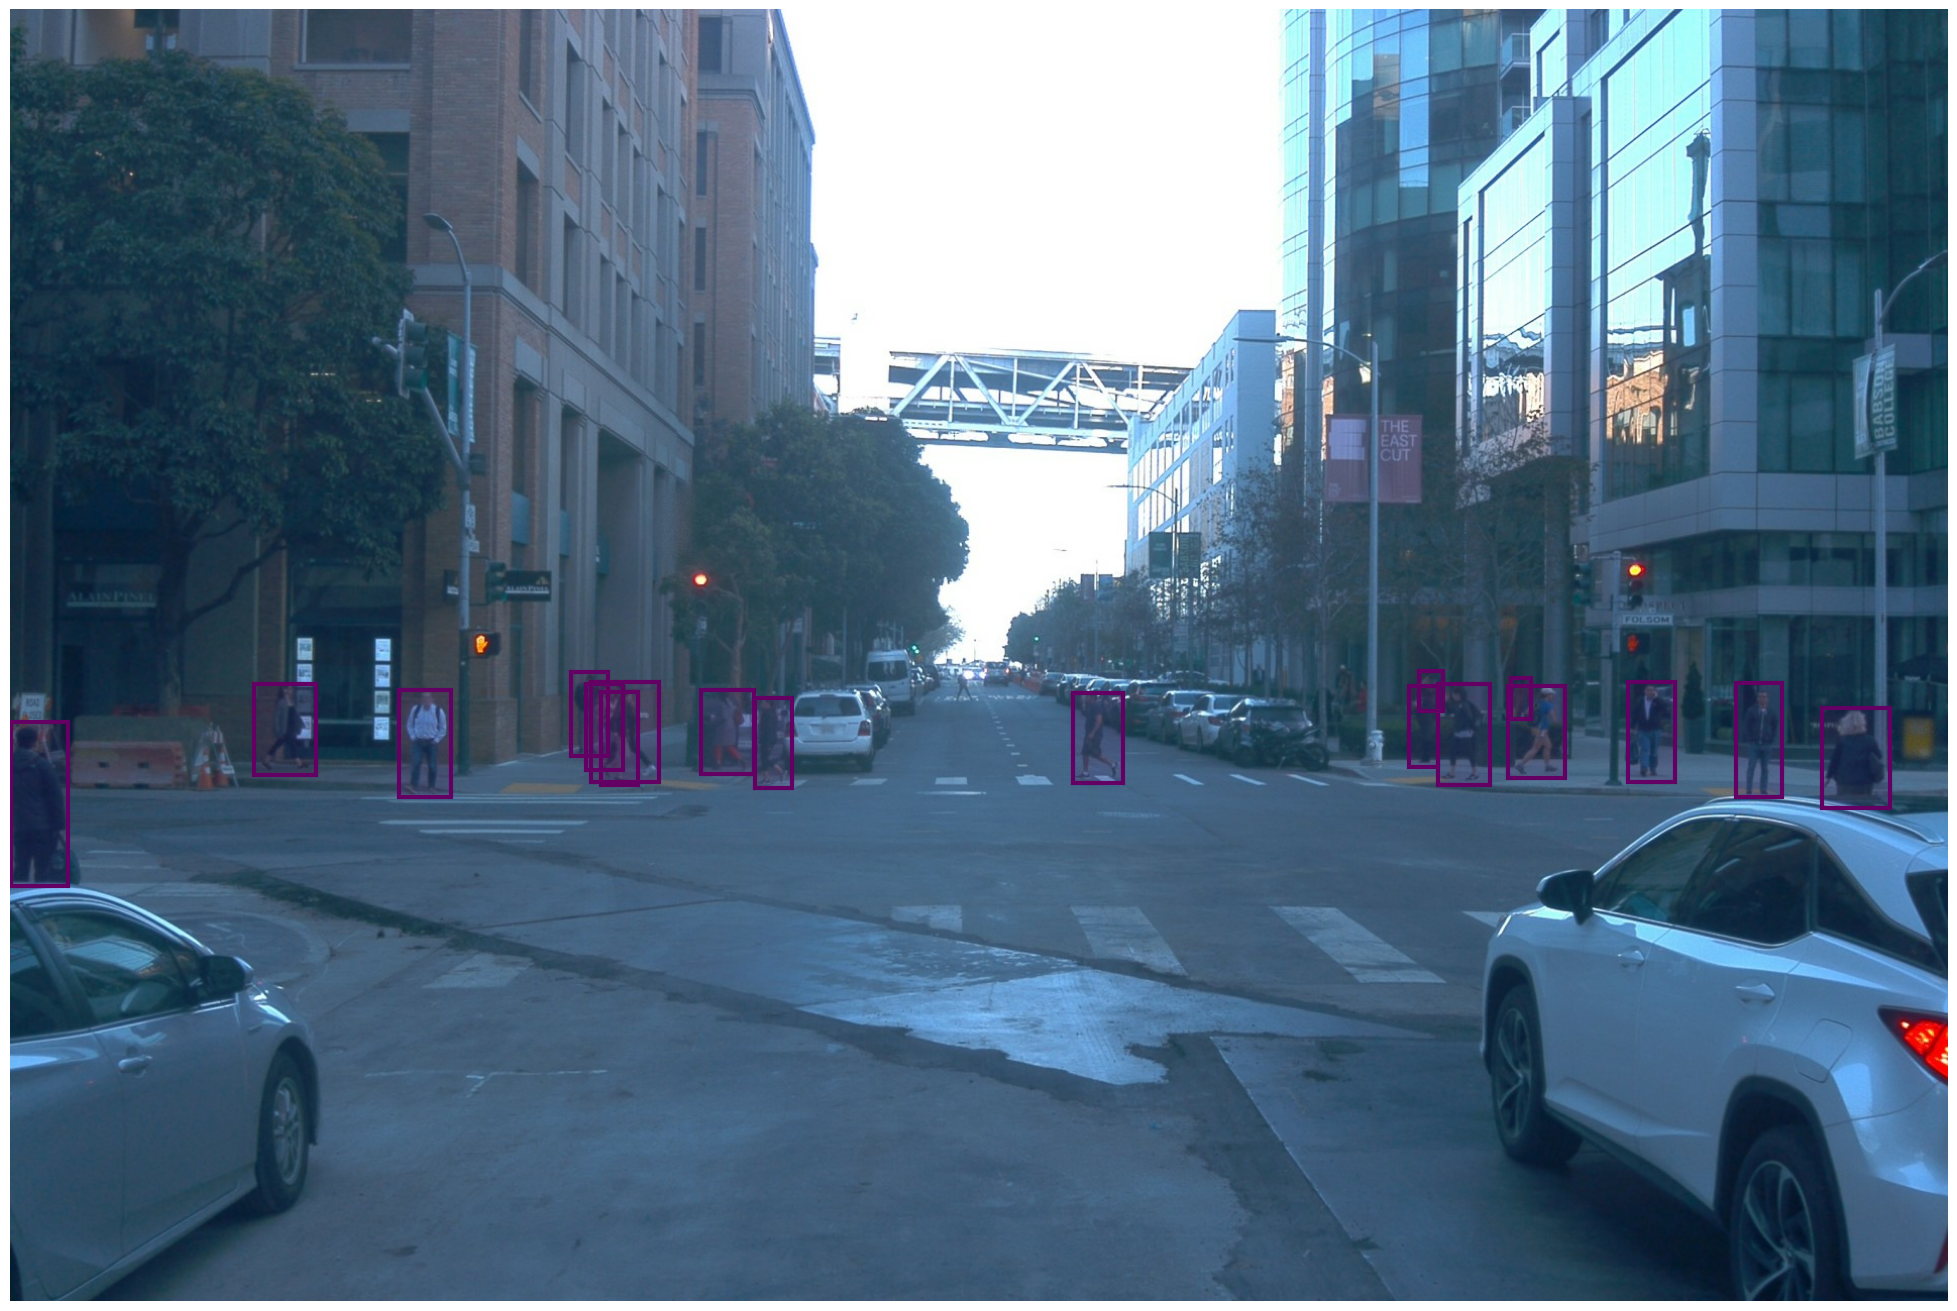

In [45]:
# Find image that is not nan
img_index = 0

while img_index < len(lidar_box.key.laser_object_id) and pd.isnull(camera_image.image[img_index]):
    img_index = img_index + 1
print("Using img: ", img_index)
img1 = tf.image.decode_jpeg(camera_image_.image[img_index_])
show_image(camera_box, img1, img_index)

In [57]:
_, row_cam_image_w_box_df = next(iter(cam_image_w_box_df.iterrows()))

camera_image1 = v2.CameraImageComponent.from_dict(row_cam_image_w_box_df)
camera_box1 = v2.CameraBoxComponent.from_dict(row_cam_image_w_box_df)
# Find image that is not nan
img_index = 0

while img_index < len(lidar_box.key.laser_object_id) and pd.isnull(camera_image.image[img_index]):
    img_index = img_index + 1
print("Using img: ", img_index)

print(camera_box1)
img2 = tf.image.decode_jpeg(camera_image1.image)
# show_image(camera_box1, img2, img_index)
cam_image_w_box_df.head()

Using img:  4
CameraBoxComponent(key=CameraLabelKey(segment_context_name='10023947602400723454_1120_000_1140_000', frame_timestamp_micros=1552440195362591, camera_name=1, camera_object_id='02f3a769-021f-49b0-b954-18e4fa1d5fde'), box=BoxAxisAligned2d(center=Vec2d(x=900.01575, y=665.69586), size=Vec2d(x=13.894980000000032, y=22.737240000000043)), type=1, difficulty_level=DifficultyLevel(detection=2.0, tracking=2.0))


,key.segment_context_name,key.frame_timestamp_micros,key.camera_name,key.camera_object_id,[CameraBoxComponent].box.center.x,[CameraBoxComponent].box.center.y,[CameraBoxComponent].box.size.x,[CameraBoxComponent].box.size.y,[CameraBoxComponent].type,[CameraBoxComponent].difficulty_level.detection,...,[CameraImageComponent].velocity.linear_velocity.x,[CameraImageComponent].velocity.linear_velocity.y,[CameraImageComponent].velocity.linear_velocity.z,[CameraImageComponent].velocity.angular_velocity.x,[CameraImageComponent].velocity.angular_velocity.y,[CameraImageComponent].velocity.angular_velocity.z,[CameraImageComponent].pose_timestamp,[CameraImageComponent].rolling_shutter_params.shutter,[CameraImageComponent].rolling_shutter_params.camera_trigger_time,[CameraImageComponent].rolling_shutter_params.camera_readout_done_time
0,10023947602400723454_1120_000_1140_000,1552440195362591,1,02f3a769-021f-49b0-b954-18e4fa1d5fde,900.01575,665.69586,13.89498,22.73724,1,2.0,...,1.337475,-1.359002,0.027288,-0.015392,0.012218,0.011145,1.552440e+09,0.006981,1.552440e+09,1.552440e+09
1,10023947602400723454_1120_000_1140_000,1552440195362591,1,0611ea50-f652-406d-942a-9ec7e3e90546,1303.60176,697.90695,29.05314,54.94833,2,NaN,...,1.337475,-1.359002,0.027288,-0.015392,0.012218,0.011145,1.552440e+09,0.006981,1.552440e+09,1.552440e+09
2,10023947602400723454_1120_000_1140_000,1552440195362591,1,08b1e19e-b912-4963-a7bb-55e138bbc25e,1828.45305,741.48666,67.58013,99.15963,2,NaN,...,1.337475,-1.359002,0.027288,-0.015392,0.012218,0.011145,1.552440e+09,0.006981,1.552440e+09,1.552440e+09
3,10023947602400723454_1120_000_1140_000,1552440195362591,1,11165fc3-e936-4722-9257-1574c6752eab,951.17454,658.74837,13.89498,15.78975,1,2.0,...,1.337475,-1.359002,0.027288,-0.015392,0.012218,0.011145,1.552440e+09,0.006981,1.552440e+09,1.552440e+09
4,10023947602400723454_1120_000_1140_000,1552440195362591,1,24508c28-3154-4b7f-964d-70b3ed7d5a9d,608.85276,715.59147,67.58013,99.15963,2,NaN,...,1.337475,-1.359002,0.027288,-0.015392,0.012218,0.011145,1.552440e+09,0.006981,1.552440e+09,1.552440e+09


In [35]:
cam_obj_df.head()

,key.segment_context_name,key.frame_timestamp_micros,key.camera_name,key.camera_object_id,key.laser_object_id,[CameraBoxComponent].box.center.x,[CameraBoxComponent].box.center.y,[CameraBoxComponent].box.size.x,[CameraBoxComponent].box.size.y,[CameraBoxComponent].type,...,[CameraImageComponent].velocity.linear_velocity.x,[CameraImageComponent].velocity.linear_velocity.y,[CameraImageComponent].velocity.linear_velocity.z,[CameraImageComponent].velocity.angular_velocity.x,[CameraImageComponent].velocity.angular_velocity.y,[CameraImageComponent].velocity.angular_velocity.z,[CameraImageComponent].pose_timestamp,[CameraImageComponent].rolling_shutter_params.shutter,[CameraImageComponent].rolling_shutter_params.camera_trigger_time,[CameraImageComponent].rolling_shutter_params.camera_readout_done_time
0,10023947602400723454_1120_000_1140_000,1552440195362591,1,08b1e19e-b912-4963-a7bb-55e138bbc25e,ZyK_iICxQsEYdJLxMFTw7w,1828.45305,741.48666,67.58013,99.15963,2,...,1.337475,-1.359002,0.027288,-0.015392,0.012218,0.011145,1.552440e+09,0.006981,1.552440e+09,1.552440e+09
1,10023947602400723454_1120_000_1140_000,1552440195362591,1,24508c28-3154-4b7f-964d-70b3ed7d5a9d,dNW3S4yA8s8GmltmAPV8LQ,608.85276,715.59147,67.58013,99.15963,2,...,1.337475,-1.359002,0.027288,-0.015392,0.012218,0.011145,1.552440e+09,0.006981,1.552440e+09,1.552440e+09
2,10023947602400723454_1120_000_1140_000,1552440195362591,1,260f57c0-787d-4f36-bfe9-64ca9828448f,8IZ7fkXm0FDeUdEuJAqSlA,410.53350,726.96009,51.79038,105.47553,2,...,1.337475,-1.359002,0.027288,-0.015392,0.012218,0.011145,1.552440e+09,0.006981,1.552440e+09,1.552440e+09
3,10023947602400723454_1120_000_1140_000,1552440195362591,1,30326915-a157-4c60-9bef-0a188938c998,brLOJzgVMhP_-kdQzIa7ng,1512.02646,715.59147,56.21151,91.58055,2,...,1.337475,-1.359002,0.027288,-0.015392,0.012218,0.011145,1.552440e+09,0.006981,1.552440e+09,1.552440e+09
4,10023947602400723454_1120_000_1140_000,1552440195362591,1,4000c3aa-c8f4-4d7c-8d9e-b082975909e6,Qk60fGhJPpHJTNmg9RXYjQ,1323.81264,670.11699,18.94770,46.73766,2,...,1.337475,-1.359002,0.027288,-0.015392,0.012218,0.011145,1.552440e+09,0.006981,1.552440e+09,1.552440e+09


In [46]:
obj_df.head()

,key.segment_context_name,key.frame_timestamp_micros,key.camera_name,key.camera_object_id,key.laser_object_id,[CameraBoxComponent].box.center.x,[CameraBoxComponent].box.center.y,[CameraBoxComponent].box.size.x,[CameraBoxComponent].box.size.y,[CameraBoxComponent].type,...,[LiDARBoxComponent].num_lidar_points_in_box,[LiDARBoxComponent].num_top_lidar_points_in_box,[LiDARBoxComponent].speed.x,[LiDARBoxComponent].speed.y,[LiDARBoxComponent].speed.z,[LiDARBoxComponent].acceleration.x,[LiDARBoxComponent].acceleration.y,[LiDARBoxComponent].acceleration.z,[LiDARBoxComponent].difficulty_level.detection,[LiDARBoxComponent].difficulty_level.tracking
0,10023947602400723454_1120_000_1140_000,1552440195362591,NaN,NaN,-U88NMYnocLWCh6iqZwj1g,NaN,NaN,NaN,NaN,NaN,...,441,438,3.420591e-04,-1.055510e-03,-1.630479e-02,8.715455e-14,2.157129e-13,-2.064473e-14,NaN,NaN
1,10023947602400723454_1120_000_1140_000,1552440195362591,NaN,NaN,0VCoeT-jjrIfzTCsOWz20A,NaN,NaN,NaN,NaN,NaN,...,97,97,-1.266784e-28,0.000000e+00,6.333921e-29,1.407538e-28,0.000000e+00,-7.037689e-29,NaN,NaN
2,10023947602400723454_1120_000_1140_000,1552440195362591,NaN,NaN,0_HBXNo3olLueqYvkPohlg,NaN,NaN,NaN,NaN,NaN,...,32,32,-1.266784e-28,-2.026855e-27,-6.333921e-29,1.407538e-28,2.252061e-27,7.037689e-29,NaN,NaN
3,10023947602400723454_1120_000_1140_000,1552440195362591,NaN,NaN,1nDCER_bA9py1ZPpNXecog,NaN,NaN,NaN,NaN,NaN,...,311,306,1.576629e-02,-1.609598e-02,-1.266784e-28,5.920294e-14,-2.589373e-13,1.407538e-28,NaN,NaN
4,10023947602400723454_1120_000_1140_000,1552440195362591,1.0,a6f937a6-7ea8-4393-b636-e0560e699856,2-A6zakvKX2opVnyx9gplQ,1440.0252,718.11783,51.79038,99.15963,2.0,...,63,63,1.056094e+00,1.221171e+00,-4.385889e-02,8.108457e-03,9.375878e-03,7.168599e-03,NaN,NaN


In [45]:
df.head()

,key.segment_context_name,key.frame_timestamp_micros,key.laser_name,[LiDARComponent].range_image_return1.values,[LiDARComponent].range_image_return1.shape,[LiDARComponent].range_image_return2.values,[LiDARComponent].range_image_return2.shape,key.camera_name,key.camera_object_id,key.laser_object_id,...,[LiDARBoxComponent].num_lidar_points_in_box,[LiDARBoxComponent].num_top_lidar_points_in_box,[LiDARBoxComponent].speed.x,[LiDARBoxComponent].speed.y,[LiDARBoxComponent].speed.z,[LiDARBoxComponent].acceleration.x,[LiDARBoxComponent].acceleration.y,[LiDARBoxComponent].acceleration.z,[LiDARBoxComponent].difficulty_level.detection,[LiDARBoxComponent].difficulty_level.tracking
0,10023947602400723454_1120_000_1140_000,1552440195362591,[1],"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[64, 2650, 4]]","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[64, 2650, 4]]","[nan, nan, nan, nan, 1.0, nan, 1.0, nan, nan, ...","[nan, nan, nan, nan, a6f937a6-7ea8-4393-b636-e...","[-U88NMYnocLWCh6iqZwj1g, 0VCoeT-jjrIfzTCsOWz20...",...,"[441, 97, 32, 311, 63, 27, 159, 12, 37, 37, 44...","[438, 97, 32, 306, 63, 27, 159, 12, 37, 37, 44...","[0.0003420591302610144, -1.266784212881428e-28...","[-0.0010555099842807093, 0.0, -2.0268547406102...","[-0.01630478676015126, 6.33392106440714e-29, -...","[8.715455277306997e-14, 1.4075378651646187e-28...","[2.1571288960008079e-13, 0.0, 2.25206058426339...","[-2.0644732082949167e-14, -7.037689325823094e-...","[nan, nan, nan, nan, nan, 2.0, nan, 2.0, nan, ...","[nan, nan, nan, nan, nan, 2.0, nan, 2.0, nan, ..."
1,10023947602400723454_1120_000_1140_000,1552440195462613,[1],"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[64, 2650, 4]]","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[64, 2650, 4]]","[nan, nan, nan, nan, 1.0, nan, 1.0, nan, nan, ...","[nan, nan, nan, nan, a6f937a6-7ea8-4393-b636-e...","[-U88NMYnocLWCh6iqZwj1g, 0VCoeT-jjrIfzTCsOWz20...",...,"[434, 93, 39, 324, 62, 29, 165, 12, 35, 29, 53...","[431, 92, 38, 319, 62, 29, 165, 12, 35, 29, 53...","[0.00034205913026972987, -1.1260305605982372e-...","[-0.001055509984259138, 0.0, -1.80164889695717...","[-0.016304786760153324, 5.630152802991186e-29,...","[8.715455277306997e-14, 1.4075378651646187e-28...","[2.1571288960008079e-13, 0.0, 2.25206058426339...","[-2.0644732082949167e-14, -7.037689325823094e-...","[nan, nan, nan, nan, nan, 2.0, nan, 2.0, nan, ...","[nan, nan, nan, nan, nan, 2.0, nan, 2.0, nan, ..."
2,10023947602400723454_1120_000_1140_000,1552440195562604,[1],"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[64, 2650, 4]]","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[64, 2650, 4]]","[nan, nan, nan, nan, 1.0, nan, 1.0, nan, nan, ...","[nan, nan, nan, nan, a6f937a6-7ea8-4393-b636-e...","[-U88NMYnocLWCh6iqZwj1g, 0VCoeT-jjrIfzTCsOWz20...",...,"[417, 98, 42, 379, 62, 30, 167, 17, 18, 31, 57...","[415, 98, 42, 361, 62, 30, 166, 17, 18, 31, 59...","[0.00034205913027844534, -9.852765727318687e-2...","[-0.0010555099842375667, 0.0, -1.5764425163709...","[-0.016304786760155388, 4.9263828636593437e-29...","[8.715455277306997e-14, 1.4075378651646187e-28...","[2.1571288960008079e-13, 0.0, 2.25206058426339...","[-2.0644732082949167e-14, -7.037689325823094e-...","[nan, nan, nan, nan, nan, 2.0, nan, 2.0, nan, ...","[nan, nan, nan, nan, nan, 2.0, nan, 2.0, nan, ..."
3,10023947602400723454_1120_000_1140_000,1552440195662587,[1],"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[64, 2650, 4]]","[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...","[[64, 2650, 4]]","[nan, nan, nan, nan, 1.0, nan, 1.0, nan, nan, ...","[nan, nan, nan, nan, a6f937a6-7ea8-4393-b636-e...","[-U88NMYnocLWCh6iqZwj1g, 0VCoeT-jjrIfzTCsOWz20...",...,"[394, 100, 39, 376, 61, 31, 172, 24, 0, 31, 61...","[391, 101, 39, 356, 61, 32, 172, 24, 0, 31, 61...","[0.00034205913028716075, -8.44522920448678e-29...","[-0.0010555099842159954, 0.0, -1.3512366727178...","[-0.016304786760157453, 4.22261460224339e-29, ...","[8.715455277306997e-14, 1.4075378651646187e-28...","[2

# Project detections into bev

In [ ]:
# project detected bounding boxes into birds-eye view
def project_detections_into_bev(bev_map, detections, configs, color=[]):
    for row in detections:
        # extract detection
        _id, _x, _y, _z, _h, _w, _l, _yaw = row

        # convert from metric into pixel coordinates
        x = (_y - configs.lim_y[0]) / (configs.lim_y[1] - configs.lim_y[0]) * configs.bev_width
        y = (_x - configs.lim_x[0]) / (configs.lim_x[1] - configs.lim_x[0]) * configs.bev_height
        z = _z - configs.lim_z[0]
        w = _w / (configs.lim_y[1] - configs.lim_y[0]) * configs.bev_width
        l = _l / (configs.lim_x[1] - configs.lim_x[0]) * configs.bev_height
        yaw = -_yaw

        # draw object bounding box into birds-eye view
        if not color:
            color = configs.obj_colors[int(_id)]
        
        # get object corners within bev image
        bev_corners = np.zeros((4, 2), dtype=np.float32)
        cos_yaw = np.cos(yaw)
        sin_yaw = np.sin(yaw)
        bev_corners[0, 0] = x - w / 2 * cos_yaw - l / 2 * sin_yaw # front left
        bev_corners[0, 1] = y - w / 2 * sin_yaw + l / 2 * cos_yaw 
        bev_corners[1, 0] = x - w / 2 * cos_yaw + l / 2 * sin_yaw # rear left
        bev_corners[1, 1] = y - w / 2 * sin_yaw - l / 2 * cos_yaw
        bev_corners[2, 0] = x + w / 2 * cos_yaw + l / 2 * sin_yaw # rear right
        bev_corners[2, 1] = y + w / 2 * sin_yaw - l / 2 * cos_yaw
        bev_corners[3, 0] = x + w / 2 * cos_yaw - l / 2 * sin_yaw # front right
        bev_corners[3, 1] = y + w / 2 * sin_yaw + l / 2 * cos_yaw
        
        # draw object as box
        corners_int = bev_corners.reshape(-1, 1, 2).astype(int)
        cv2.polylines(bev_map, [corners_int], True, color, 2)

        # draw colored line to identify object front
        corners_int = bev_corners.reshape(-1, 2)
        cv2.line(bev_map, (int(corners_int[0, 0]), int(corners_int[0, 1])), (int(corners_int[3, 0]), int(corners_int[3, 1])), (255, 255, 0), 2)


## Add boxes

In [ ]:
def addBoxes(results):
    for result in results:
        boxes = result.boxes
        probs = result.probs
        img = result.orig_img
        classes = boxes.cls.cpu().numpy()
        names = result.names
        # print(boxes, ', prob:')
        for i, xyxy in enumerate(boxes.xyxy.cpu().numpy()):
            # print(xyxy[0])
            cls = classes[i]

            if int(cls) in colors_map:
                color = colors_map[cls]
                cv2.rectangle(img, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), thickness=2, color=color)
                cv2.putText(img, names[int(cls)], (int(xyxy[0]), int(xyxy[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color=color, thickness=2)
            
    cv2.imshow('Camera and detected objects', img)
    cv2.waitKey(0) 
    return img

In [ ]:
# Utility for fixing 
range_image = v2.perception.lidar.RangeImage(lidar.range_image_return1.values[0], lidar.range_image_return1.shape[0])

print(range_image.values)
print(type(range_image))
print(type(range_image_orig))
rit = range_image.tensor
print(rit)
print(type(rit))
# tf.convert_to_tensor(lidar_calibration.extrinsic.transform.tolist())

points = v2.perception.utils.lidar_utils.convert_range_image_to_point_cloud(range_image, lc2, keep_polar_features=True)

In [26]:
row

key.segment_context_name                                                             10023947602400723454_1120_000_1140_000
key.frame_timestamp_micros                                                                                 1552440195362591
key.laser_name                                                                                                          [1]
[LiDARComponent].range_image_return1.values                               [[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...
[LiDARComponent].range_image_return1.shape                                                                  [[64, 2650, 4]]
[LiDARComponent].range_image_return2.values                               [[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...
[LiDARComponent].range_image_return2.shape                                                                  [[64, 2650, 4]]
key.camera_name                                                           [nan, nan, nan, nan, 1.0, nan, 1.0, nan, nan, ...
key.came